In [ ]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Point

import pysal as ps
from pysal.esda.getisord import G
from pysal.esda.getisord import G_Local

from matplotlib import pyplot as plt
from pylab import figure, scatter, show
import seaborn as sns

In [ ]:
shpPath = "data/shapefiles/pivoted_averaged_turnstile_data.shp"

stationData = gpd.read_file(shpPath)
nyc_streets = gpd.read_file("visualization/basemap/nyc_streets.shp")

listOfTimes = list(stationData.columns)[1:-1]

# ESDA

In [ ]:
output_path = 'visualization/esda'

for i in range(len(listOfTimes)):

    vmin, vmax = -.1, .1

    base = nyc_streets.plot(color='black', linewidth=0.25, alpha=.1)
    fig = stationData.plot(ax=base, column=listOfTimes[i], legend=True, figsize=(10,10), markersize=1, vmin=vmin, vmax=vmax, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    fig.axis('off')
    fig.figsize=(10,10)
    fig.set_title('Station Intensity', fontdict={'fontsize': '25', 'fontweight' : '3'})
    fig.annotate(listOfTimes[i], xy=(0.1, .15), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=15)
    
    filepath = os.path.join(output_path, listOfTimes[i] +'_intensity_timemap.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=75)

# Weights & Spatial Lags

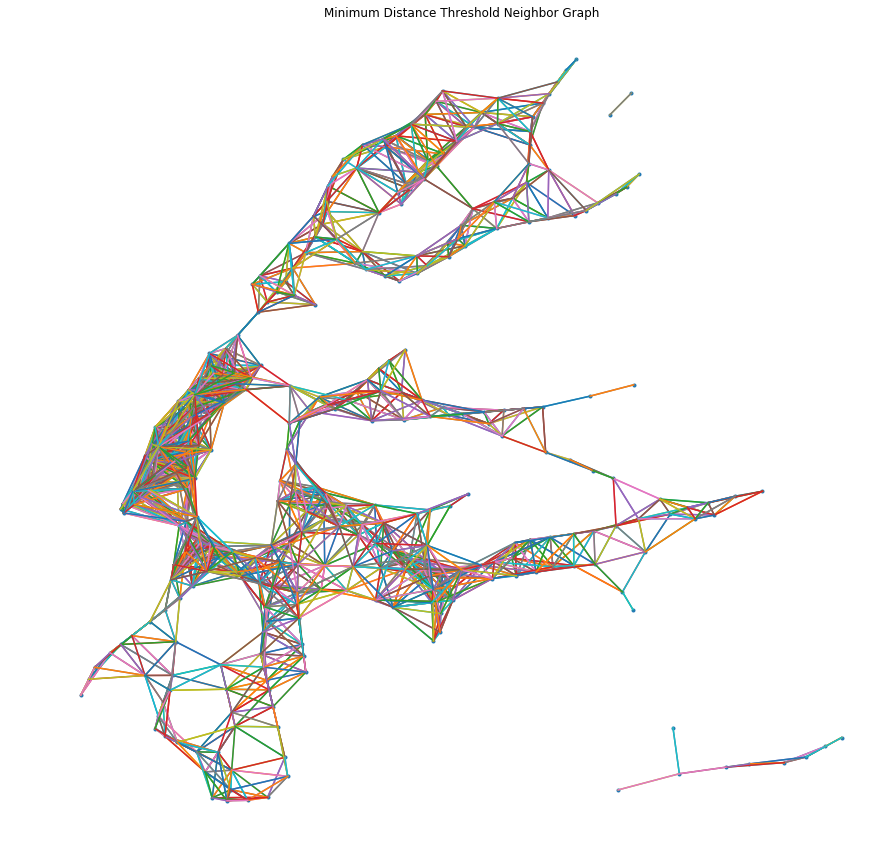

In [4]:
centroids = np.array(list(zip(stationData.geometry.apply(lambda p: p.x), stationData.geometry.apply(lambda p: p.y))))
threshold = ps.min_threshold_dist_from_shapefile(shpPath)
gravityModel = ps.weights.DistanceBand.from_shapefile(shpPath, threshold, alpha = -2.0, binary = False)

fig = figure(figsize=(15,15))
plt.axis('off')
plt.plot(centroids[:,0], centroids[:,1],'.')
for k,neighbors in gravityModel.neighbors.items():
    origin = centroids[k]
    for neighbor in neighbors:
        segment = centroids[[k,neighbor]]
        plt.plot(segment[:,0], segment[:,1], '-')
plt.title('Minimum Distance Threshold Neighbor Graph')
plt.savefig('visualization/weights/station_distancethreshold_neighbors.png');
plt.show()

In [ ]:
threshold = ps.min_threshold_dist_from_shapefile(shpPath)
gravityModel = ps.weights.DistanceBand.from_shapefile(shpPath, threshold, alpha = -2.0, binary = False, idVariable='STATION')

weightsFile = ps.open('data/weights/gravity_weights.gal', 'w')
weightsFile.write(gravityModel)
weightsFile.close;

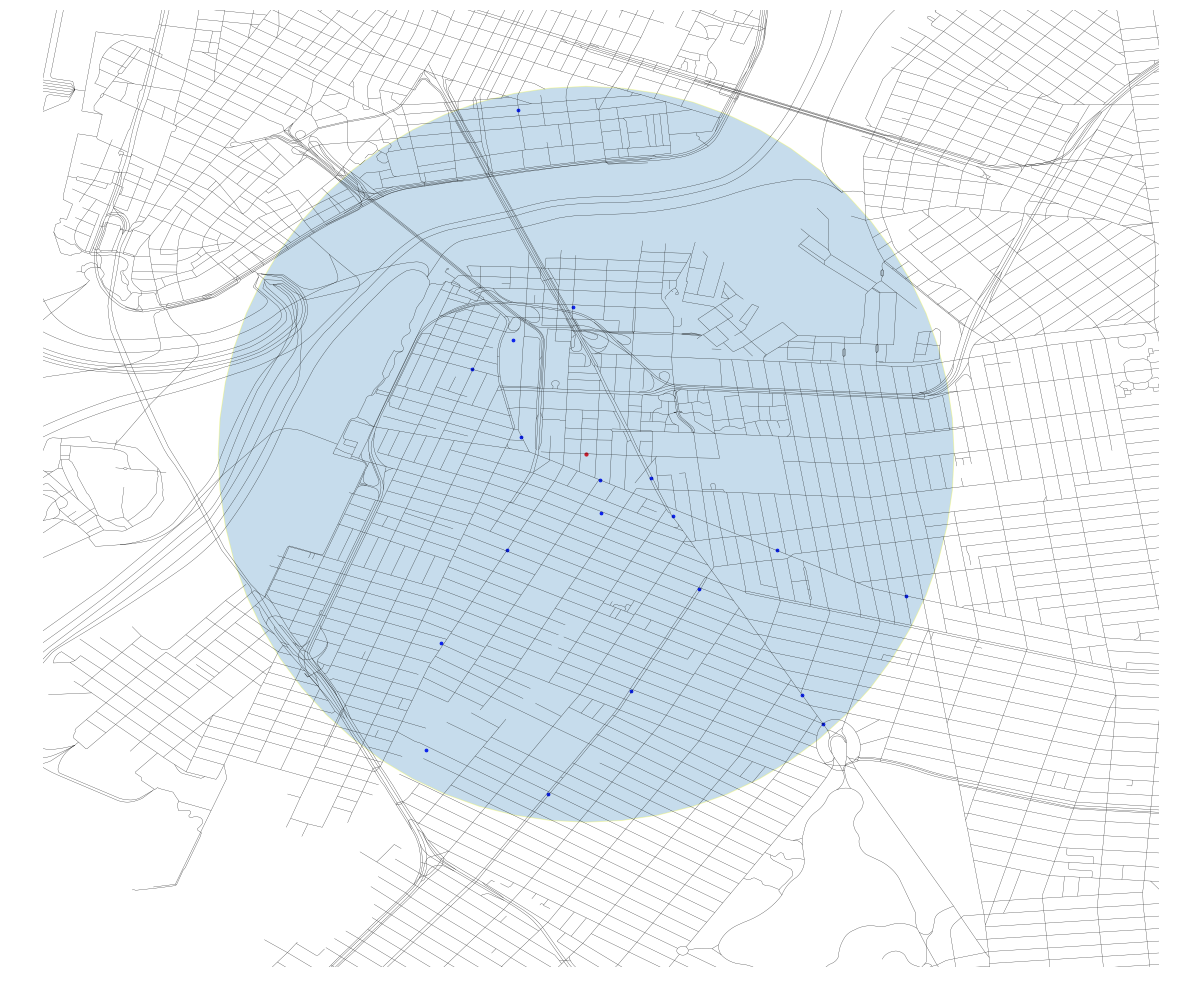

In [6]:
focus = stationData[stationData.STATION == 'Jay St - MetroTech']
focus = focus.to_crs(epsg=4326)
buffer = focus.buffer(threshold)

neighbors = pd.DataFrame()
for neighbor in gravityModel['Jay St - MetroTech']:
    neighbors = neighbors.append(stationData[stationData.STATION == neighbor])
neighbors = gpd.GeoDataFrame(neighbors.geometry)

fig, ax = plt.subplots(figsize=(20, 20))
plt.axis('off')

ax.set_aspect('equal')
ax.set_xlim(-74.02,-73.95)
ax.set_ylim(40.66,40.72)

nyc_streets.plot(ax=ax, color='black', linewidth=0.25)
focus.plot(ax=ax, marker='o', color='red', markersize=10)
neighbors.plot(ax=ax, marker='o', color='blue', markersize=7.5)
buffer.plot(ax=ax, edgecolor='yellow', alpha=.25)

plt.savefig('visualization/weights/jayst_neighbors.png');
plt.show();

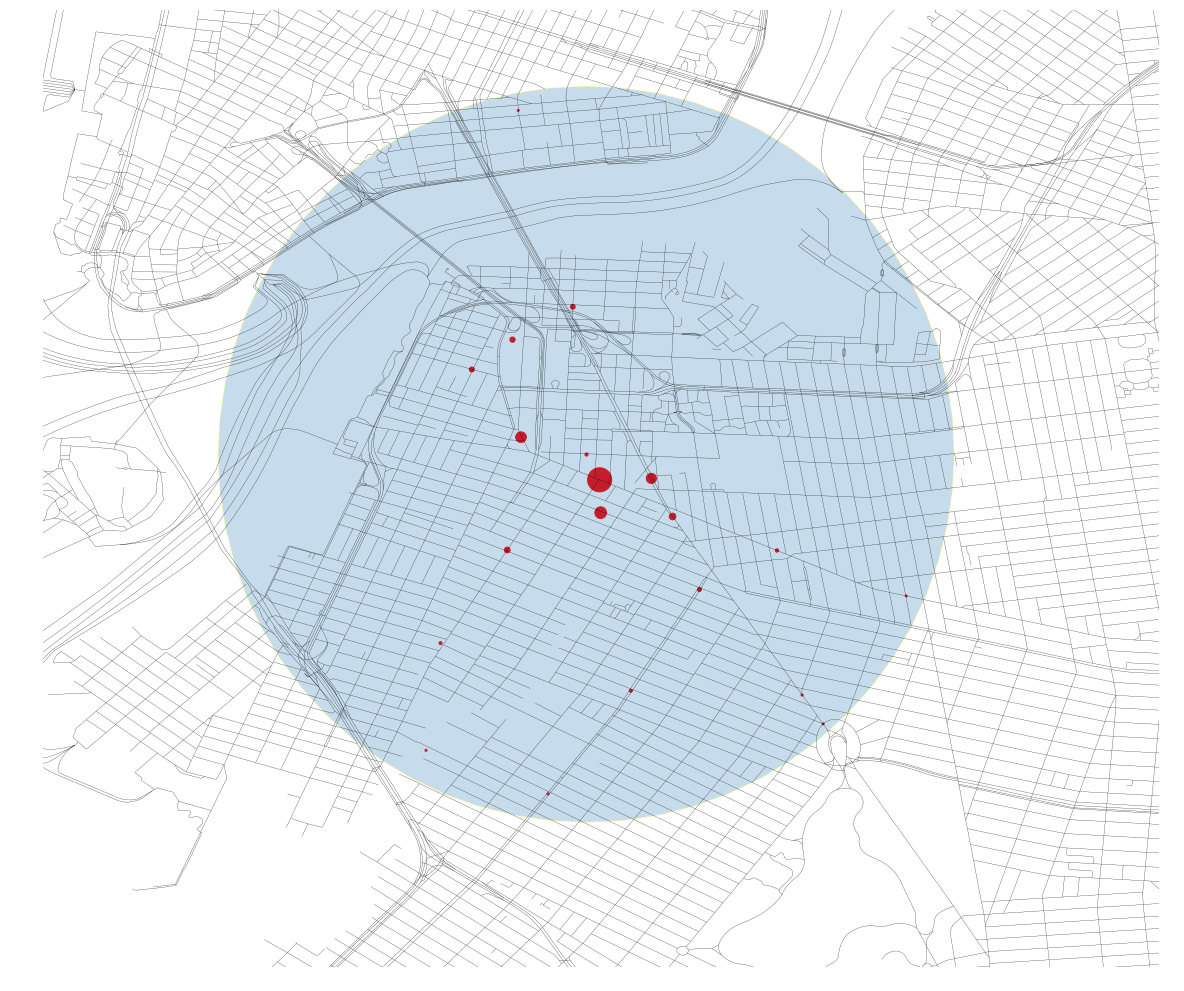

In [7]:
focus = stationData[stationData.STATION == 'Jay St - MetroTech']
focus = focus.to_crs(epsg=4326)
buffer = focus.buffer(threshold)

jaySt = pd.DataFrame.from_dict(gravityModel['Jay St - MetroTech'],orient='index')
jaySt.reset_index(inplace=True)
jaySt.columns = ['STATION', 'gravityWeight']

neighbors = pd.DataFrame()
for nei in gravityModel['Jay St - MetroTech']:
    neighbors = neighbors.append(stationData[stationData.STATION == nei])
neighbors = neighbors[['STATION', 'geometry']].merge(jaySt, on='STATION')


fig, ax = plt.subplots(figsize=(20, 20))
plt.axis('off')
ax.set_aspect('equal')
ax.set_xlim(-74.02,-73.95)
ax.set_ylim(40.66,40.72)

nyc_streets.plot(ax=ax, color='black', linewidth=0.25)
focus.plot(ax=ax, marker='o', color='red', markersize=10)
neighbors.plot(ax=ax, marker='o', color='red',markersize=(neighbors['gravityWeight']/500))
buffer.plot(ax=ax, edgecolor='yellow', alpha=.25)

plt.savefig('visualization/weights/jayst_neighbors_weights.png');
plt.show();

In [ ]:
gravityModel.transform = 'r'

output_path = 'visualization/spatiallag'

for i in range(len(listOfTimes)):
    
    base = nyc_streets.plot(color='black', linewidth=.25, alpha=.1);
    lag = ps.Quantiles(ps.lag_spatial(gravityModel, stationData[listOfTimes[i]]), k=10)

    fig = stationData.assign(cl=lag.yb).plot(ax= base, column='cl', legend=True, markersize=5, figsize=(5,5));
    fig.axis('off')
    fig.set_title('Station Spatial Lag', fontdict={'fontsize': '25', 'fontweight' : '3'})
    fig.annotate(listOfTimes[i], xy=(0.1, .15), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=15)
    
    filepath = os.path.join(output_path, listOfTimes[i] +'_spatiallag.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=50)

# Moran Scatterplot

In [ ]:
gravityModel.transform = 'r'

output_path = 'visualization/moran'

for i in range(len(listOfTimes)):
    
    spatial_lag = pd.Series(ps.lag_spatial(gravityModel, stationData[listOfTimes[i]]), index=stationData[listOfTimes[i]].index)

    fig, ax = plt.subplots(1, figsize=(9, 9))
    fig = sns.regplot(x=stationData[listOfTimes[i]], y=spatial_lag)

    plt.axvline(0, c='k', alpha=0.5)
    plt.axhline(0, c='k', alpha=0.5)
    plt.title('Moran Scatter Plot', fontdict={'fontsize': '25', 'fontweight' : '3'})

    filepath = os.path.join(output_path, listOfTimes[i] +'_moranscatter.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)

# Global Moran's I

In [ ]:
morans_i = []
morans_i_pvalue = []

for i in range(len(listOfTimes)):
    mi = ps.Moran(stationData[listOfTimes[i]], gravityModel)
    morans_i.append(mi.I)
    morans_i_pvalue.append(mi.p_sim)
    
morans = pd.DataFrame(np.column_stack([listOfTimes, morans_i, morans_i_pvalue]), columns=['TIME', 'I', 'P'])

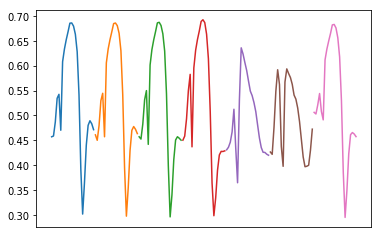

In [19]:
morans['RANGE'] = range(0,len(morans))
morans['I'] = morans['I'].astype(float)

moran_monday = morans[:24]
moran_tuesday = morans[24:48]
moran_wednesday = morans[48:72]
moran_thursday = morans[72:96]
moran_friday = morans[96:120]
moran_saturday = morans[120:144]
moran_sunday = morans[144:]

moranDays = [moran_monday, moran_tuesday, moran_wednesday, moran_thursday, moran_friday, moran_saturday, moran_sunday]

for day in moranDays:
    plt.plot(day.RANGE, day.I);
    plt.xticks([])
    plt.savefig("visualization/moran/morans_overweek.png")

# Local Autocorrelation (LISA)

In [ ]:
output_path = 'visualization/lisa'

for i in range(len(listOfTimes)):

    lisa = ps.Moran_Local(stationData[listOfTimes[i]].values, gravityModel)

    tempData = stationData.iloc[:,[0,i,-1]]
    tempData['significant'] = lisa.p_sim < 0.05
    tempData['quadrant'] = lisa.q
    
    hh = tempData.loc[(tempData['quadrant']==1) & (tempData['significant']==True), 'geometry']
    ll = tempData.loc[(tempData['quadrant']==3) & (tempData['significant']==True), 'geometry']
    lh = tempData.loc[(tempData['quadrant']==2) & (tempData['significant']==True), 'geometry']
    hl = tempData.loc[(tempData['quadrant']==4) & (tempData['significant']==True), 'geometry']

    fig, ax = plt.subplots(figsize=(25,25))
    ax.set_aspect('equal')

    nyc_streets.plot(ax=ax, color='black', linewidth=0.25, alpha=.1)
    hh.plot(ax=ax, color='red')
    ll.plot(ax=ax, color='blue')
    lh.plot(ax=ax, color='yellow')
    hl.plot(ax=ax, color='yellow')
    
    plt.axis("off")
    plt.title('LISA', fontdict={'fontsize': '25', 'fontweight' : '3'})
    
    fig.annotate(listOfTimes[i], xy=(0.1, .15), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=15) 
    filepath = os.path.join(output_path, listOfTimes[i] +'_lisa.png')
    fig.savefig(filepath, dpi=300)

# Getis Ord

In [ ]:
g_g = []
g_p = []

for i in range(len(listOfTimes)):
    g = ps.G(stationData[listOfTimes[i]], gravityModel)
    g_g.append(g.G)
    g_p.append(g.p_norm)
    
getis = pd.DataFrame(np.column_stack([listOfTimes, g_g, g_p]), 
                               columns=['TIME', 'G', 'P'])

getis = getis[getis.P.astype(float) < 0.05]

In [ ]:
points_list = []
for i in range(len(listOfTimes)):

    lg = G_Local(stationData[listOfTimes[i]], gravityModel, transform='R', star=True)
    significantG = [lg.p_norm < 0.05]
    significant_points = gravityModel.data[significantG[0] == True]
    
    points = []
    for i in range(len(significant_points)):
        point = Point(significant_points[i][0], significant_points[i][1])
        points.append(point)
    
    points_list.append(points)

points_final = []
for points in points_list:
    points_final.append(gpd.GeoSeries(points))

In [ ]:
output_path = 'visualization/getis'
for i in range(len(listOfTimes)):

    if len(points_final[i].values) > 0:
        fig, ax = plt.subplots(figsize=(25,25))
        ax.set_aspect('equal')
        nyc_streets.plot(ax=ax, color='black', linewidth=0.25, alpha=.1)
        points_final[i].plot(ax=ax, color='red', markersize=5)

        plt.axis("off")
        plt.title('Getis Ord Local', fontdict={'fontsize': '25', 'fontweight' : '3'})
    
        plt.annotate(listOfTimes[i], xy=(0.1, .15), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=15)
        filepath = os.path.join(output_path, listOfTimes[i] +'_getis.png')
        fig.savefig(filepath, dpi=300)
    
    else:
        continue